# Fraud Analytics Assignment 1

CS20BTECH11004 Aman Panwar\
AI20BTECH11003 Amulya Tallamraju\
ES20BTECH11035 Pranav K Nayak\
CS20BTECH11052 Taha Adeel Mohammed\
CS20BTECH11056 Vikhyath Sai Kothamasu




In [ ]:
# Install the following if running on Colab
# !pip install node2vec
# !pip install kneed

In [ ]:
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns
import networkx as nx
from node2vec import Node2Vec
from kneed import KneeLocator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors

sns.set()
random.seed(0)
np.random.seed(0)

## Data Loading

In [ ]:
df = pd.read_csv('Iron_dealers_data.csv')
df.head()

# Create edge-weighted graph from DataFrame
G = nx.MultiDiGraph()
for i, row in df.iterrows():
    seller = row['Seller ID']
    buyer = row['Buyer ID']
    value = row['Value']
    G.add_edge(seller, buyer, weight=value)
print(G)

MultiDiGraph with 799 nodes and 130535 edges


## Converting to Directed Graph

The algorithm below converts a directed multi graph to an undirected graph

Here are some things the weight should indicate:
1. More the number of number of cycles more the weight
1. More the amount of money in any cycle more the weight
1. If the amount of money in each step of the cycle remains somewhat same then more weight. 
1. Weight should also sense a difference in between nodes with many cycles but low amount of money in them and nodes with fewer cycles but proportionally more money in them

$C$: Set of 2 cycles and 3 cycles from u->v\
We limit to 2 and 3 cycles since even taking 4 cycles takes exponentially more time and is not feasible to calculate \


$score(c)$: represent the score for a cycle c. Assigns a larger weight proportional to avg amount of cycle. and assigns a lower weight when the difference between min and max is high\
$score(c) =  \begin{cases} 
\text{avg amount in cycle}    \text{‎ ‎ ‎ ‎ ‎ ‎ ‎ ‎ if} (max(c)-min(c))/min(c)<0.1,\\
 \frac{\text{avg amount in cycle}}{100}\text{‎‎ ‎ ‎ ‎ ‎ ‎ ‎ ‎ ‎ ‎ ‎‎‎‎‎ ‎ ‎ ‎ ‎ ‎ ‎ if} (max(c)-min(c))/min(c)>0.1
 \end{cases}$ 
 
weight of edge between node 'u' and 'v': $\sqrt{ \sum _{c \in C}{{score(c)}^2}}$

The weight takes the scores are squared and added to allow for a sense of difference between nodes with low number of cycle with high score and nodes with high number of cycles with proportionally low score.

In [ ]:
def convert_to_undirected_graph(G:nx.MultiDiGraph) -> nx.Graph:
    """convert an input multidigraph to an undirected graph
        shows the distribution of assigned weights by graphing in increasing order.
        read more on the algorithm used in the markdown cell above
    """
    R= nx.Graph() #resultant Graph
    
    edge_dict = {}  #dict (u,v): [weights of edges from u->v] for every node u, v in G
    nodes = set()   #all unique nodes in G
    for u, v, i, w in G.edges(data='weight', keys=True):
        edge_dict.setdefault((u,v), []).append(w)
        nodes.add(u)
        nodes.add(v)

    def cycle2(u,v):
        """find the all the 2cycles between node u and v.\ 
            returns an array where every element is an array representing the weights in one of the 2cycles"""
        if (u,v) in edge_dict:
            if (v,u) in edge_dict:
                return [ [a]+[b]  for (a,b) in itertools.product(edge_dict[(u,v)], edge_dict[(v,u)])]
        return []      
    
    def cycle3(u,v):
        """find the all the 3cycles between node u and v.\ 
            returns an array where every element is an array representing the weights in one of the 3cycles"""
        if (u, v) not in edge_dict: return []
        res = []
        for x in nodes:
            if (v,x) in edge_dict:
                if (x,u) in edge_dict:
                    p = [ [a]+[b]  for (a,b) in itertools.product(edge_dict[(v,x)], edge_dict[(x,u)])]
                    for t in p:
                        t+= edge_dict[(u,v)]
                        res.append(t)
        return res
    
    weights = [] #weight assigned to all the edges. needed for the graph
    
    for (u,v) in edge_dict: #for every pair of node u->v in G
        w = 0 #edge weight
        
        for x in cycle2(u,v)+cycle3(u,v):#for every 2cycle or 3cycle bw u->v
            avg = sum(x)/len(x) #avg amount of money in the particular cycle
             
             # if weight of max amount and min amount
             # in the cycle differ by 10%, that cycle contributes less weight
            if (max(x) - min(x))/min(x) < 0.1: #
                w+=(1 *avg)**2 
            else:
                w+=(0.01*avg)**2
       
        w=np.sqrt(w)
        weights.append(w)
        if w>0: 
            if R.has_edge(v,u):
                R[v][u]['weight']+=w
            else:
                R.add_edge(u,v, weight = w)
    
    max_w=max(weights)
    weights = weights/max_w
    
    #normalising weights 
    for u,v, data in R.edges(data=True):
        data['weight'] = data['weight']/max_w 

    weights.sort()
    plt.plot(range(len(weights)), weights)
    plt.title('distribution of edge weights')
    plt.ylabel('weights')
    
    return R

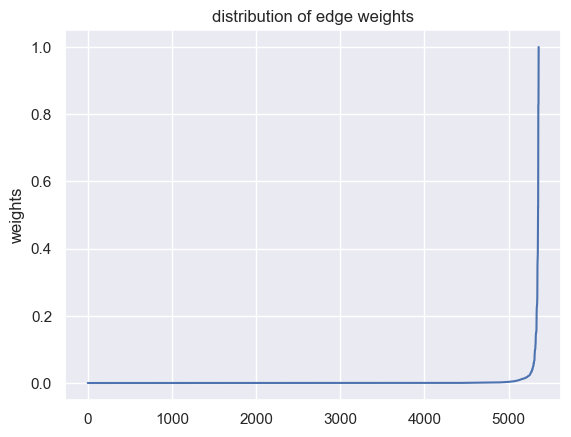

In [ ]:
G = convert_to_undirected_graph(G)

Most edges have very low weight. A few edges have very high weight, these edges are highly likely to be involved in fraud.

#### Visualising resultant graph
Darker the colour of edge -> higher the weight

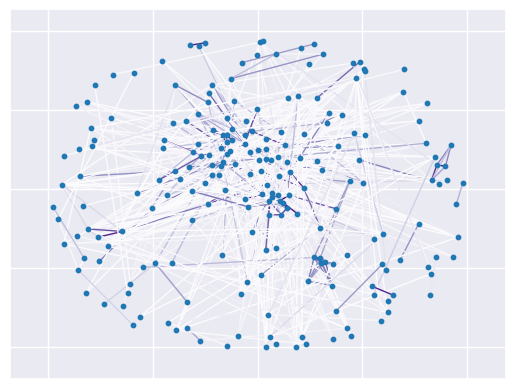

In [ ]:
def line_Weight(x):
    return np.ceil(1000 * np.exp(4 * x))

pos = nx.spring_layout(G)
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
weights =list(weights)
import scipy.stats as ss
weights = [line_Weight(x/len(weights)) for x in ss.rankdata(weights)]

weights=tuple(weights)
nx.draw_networkx(G, pos, arrows = False, with_labels=False, node_size=10, width=[ 1 for _, _, d in G.edges(data=True)], edgelist = edges, edge_color  =weights,edge_cmap = plt.cm.Purples)

## Embedding and Classification

#### Embedding creating embedding for the graph with Node2vec

In [ ]:
# Learn node embeddings using Node2Vec
n_nodes = G.number_of_nodes()
node2vec = Node2Vec(G, dimensions=int(np.sqrt(n_nodes)), walk_length=16, num_walks=100, workers=8)
model = node2vec.fit( window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/215 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 12/12 [00:00<00:00, 67.25it/s]


#### Dimensionality Reduction to get better classification

In [ ]:
#dimensionality reduction using TSNE to help in clustering. #dimensionality curse
X1=model.wv.vectors
X = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X1)
X_=X / X.max(axis=0)

#### Clustering with DBScan

In [ ]:
# clustering with DBScan 
clusters = DBSCAN(eps=0.0325, min_samples=4).fit(X_)

## Results


#### Distribution of point in cluster

number of point in each cluster are relevant since a cluster should not have too high or too low # of points

In [ ]:
label_dict = {}
for i, x in enumerate(X_):
    key = clusters.labels_[i]
    label_dict.setdefault(key, [])
    label_dict[key].append(x)


print('number of point in cluster:')
for x in label_dict:
    if x  == -1: continue
    print(f"cluster {x} :\t{len(label_dict[x])}")

number of point in cluster:
cluster 1 :	4
cluster 0 :	4
cluster 11 :	5
cluster 2 :	5
cluster 9 :	5
cluster 3 :	4
cluster 4 :	4
cluster 10 :	4
cluster 5 :	4
cluster 12 :	5
cluster 6 :	4
cluster 7 :	4
cluster 8 :	4


#### Visualising Clusters

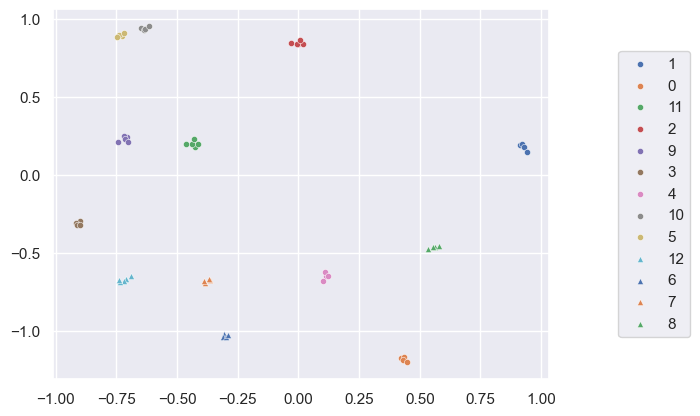

In [ ]:
m= ['o', '^', 'D', '*', '+', '8', 'x', 'p', 's'] #style of point in a graph
for i, label in enumerate(label_dict):
    if label == -1:continue 
    data = np.array(label_dict[label])
    sns.scatterplot(x = data[:, 0], y=data[:, 1],label =label, legend = "full", marker = m[(i//10)%len(m)], s=20)
plt.legend(bbox_to_anchor=(1.3, 0.5), loc = 'right')
plt.show()

#### Nodes in the clusters

In [ ]:
node_ids = model.wv.index_to_key  # list of node IDs

#putting the node ids in a dataframe with cluster number
data_tsne = pd.DataFrame(zip(node_ids, list(X_[:,0]),list(X_[:,1]),clusters.labels_),
                        columns = ['node_ids','x','y','cluster_id'])

In [ ]:
print('Nodes in clusters:')
label_W_nodes= {}
for x, l in zip(data_tsne.node_ids, data_tsne.cluster_id):
    label_W_nodes.setdefault(l ,[])
    label_W_nodes[l].append(x)

for l in label_W_nodes:
    if l==-1:continue
    print(f'cluster {l}: {label_W_nodes[l]}')

Nodes in clusters:
cluster 1: ['1007.0', '1038.0', '1050.0', '1534.0']
cluster 0: ['1245.0', '1108.0', '1220.0', '1141.0']
cluster 11: ['1138.0', '1419.0', '1158.0', '1324.0', '1317.0']
cluster 2: ['1356.0', '1149.0', '1254.0', '1251.0', '1113.0']
cluster 9: ['1035.0', '1073.0', '1126.0', '1471.0', '1431.0']
cluster 3: ['1330.0', '1381.0', '1250.0', '1043.0']
cluster 4: ['1004.0', '1172.0', '1136.0', '1104.0']
cluster 10: ['1133.0', '1159.0', '1305.0', '1640.0']
cluster 5: ['1114.0', '1067.0', '1065.0', '1155.0']
cluster 12: ['1210.0', '1626.0', '1258.0', '1057.0', '1048.0']
cluster 6: ['1355.0', '1214.0', '1215.0', '1314.0']
cluster 7: ['1318.0', '1376.0', '1319.0', '1370.0']
cluster 8: ['1076.0', '1075.0', '1580.0', '1510.0']
